### set folder_name and day session to analyze

In [13]:
name = 'ANM7'
session = '20240130_d1'

### imports

In [14]:
from scipy import io
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import statistics
import re
import glob
import scipy.signal as signal
import pickle

from common.load_tonedisc_matfile import load_tonedisc_matfile
from common.align_times import get_leverdata_indices
from preprocess_leverdata.get_trial_frequencies import get_trial_frequencies
from preprocess_leverdata.butterworth_filter_leverdata import butterworth_filter_leverdata
from preprocess_leverdata.rescale_leverdata import rescale_leverdata
from preprocess_leverdata.view_processed_trial_FFT import view_processed_trial_FFT
from preprocess_leverdata.calculate_leverdata_sample_times import calculate_leverdata_sample_times

### Setup folders and matfiles

In [15]:
tone_discriminiation_matfile = '../Data_Copy/ToneDiscriminationData/'+name+'/ToneDisc_'+name+'_'+session+'.mat'
params, response, arduino, respMTX, MTXTrialType = load_tonedisc_matfile(tone_discriminiation_matfile)

output_folder = "../Data_Copy/AnalysisData/"+name+"/PreprocessLeverData_"+name+"_"+session+"/"
leverdata_matfile = "../Data_Copy/LeverData/"+name+"/LeverData_"+name+"_"+session+".mat"

respMTX shape: (54, 7)
MTXTrialType shape: (1000, 5)
number of trials: 54


In [16]:
open(leverdata_matfile)

<_io.TextIOWrapper name='../Data_Copy/LeverData/ANM7/LeverData_ANM7_20240130_d1.mat' mode='r' encoding='UTF-8'>

For mac:

In [17]:
!mkdir {output_folder}

mkdir: ../Data_Copy/AnalysisData/ANM7/PreprocessLeverData_ANM7_20240130_d1/: File exists


For windows:

In [18]:
!mkdir "{output_folder}"

mkdir: ../Data_Copy/AnalysisData/ANM7/PreprocessLeverData_ANM7_20240130_d1/: File exists


preview trials

In [19]:
respMTX.shape

(54, 7)

In [20]:
respMTX_shape = respMTX.shape[0]
np.set_printoptions(suppress = True,
   formatter = {'float_kind':'{:f}'.format})
print(np.hstack((respMTX[1:respMTX_shape, 0:1]-respMTX[0:respMTX_shape-1, 0:1], np.array([np.linspace(0, respMTX_shape-2, respMTX_shape-1)]).transpose())))

[[9.788656 0.000000]
 [11.815893 1.000000]
 [25.627311 2.000000]
 [7.183123 3.000000]
 [12.783934 4.000000]
 [9.129263 5.000000]
 [12.348188 6.000000]
 [7.849333 7.000000]
 [7.376110 8.000000]
 [8.163235 9.000000]
 [7.874665 10.000000]
 [12.686383 11.000000]
 [9.326425 12.000000]
 [36.783645 13.000000]
 [8.812011 14.000000]
 [10.337000 15.000000]
 [26.915742 16.000000]
 [19.670894 17.000000]
 [36.048750 18.000000]
 [9.590087 19.000000]
 [36.241779 20.000000]
 [22.264019 21.000000]
 [8.973410 22.000000]
 [36.991553 23.000000]
 [22.247730 24.000000]
 [37.110638 25.000000]
 [25.006971 26.000000]
 [35.788521 27.000000]
 [36.963919 28.000000]
 [36.519214 29.000000]
 [19.149891 30.000000]
 [70.503575 31.000000]
 [10.762509 32.000000]
 [22.774592 33.000000]
 [28.814812 34.000000]
 [22.902610 35.000000]
 [37.342695 36.000000]
 [8.447748 37.000000]
 [21.034127 38.000000]
 [12.350967 39.000000]
 [16.297810 40.000000]
 [16.230121 41.000000]
 [24.945341 42.000000]
 [31.641860 43.000000]
 [36.59683

### Run leverdata2binary.cpp to create binary files for each trial from `lever_data` in the LeverData .mat file

In [21]:
!./preprocess_leverdata/leverdata2binary {output_folder} {leverdata_matfile} 50429

leverdata from .mat size: 72000000,72000000
leverdata from .mat rank: 2
leverdata vector size: 72000000
leverdata vector with unused rows taken out size: 8227720
vector saved to .bin file ../Data_Copy/AnalysisData/ANM7/PreprocessLeverData_ANM7_20240130_d1/full.bin
finished a trialITI: 102794 index:0 trialITI length: 52365 samples = ~8s
vector saved to .bin file ../Data_Copy/AnalysisData/ANM7/PreprocessLeverData_ANM7_20240130_d1/trial0.bin
finished a trialITI: 181017 index:1 trialITI length: 78223 samples = ~13s
vector saved to .bin file ../Data_Copy/AnalysisData/ANM7/PreprocessLeverData_ANM7_20240130_d1/trial1.bin
finished a trialITI: 323881 index:2 trialITI length: 142864 samples = ~24s
vector saved to .bin file ../Data_Copy/AnalysisData/ANM7/PreprocessLeverData_ANM7_20240130_d1/trial2.bin
finished a trialITI: 370431 index:3 trialITI length: 46550 samples = ~7s
vector saved to .bin file ../Data_Copy/AnalysisData/ANM7/PreprocessLeverData_ANM7_20240130_d1/trial3.bin
finished a trialITI:

change `num_trials` if seems like `lever_data` stopped before behavior (if total trials detected is less than `num_trials` from `respMTX`)

In [22]:
num_trials = 53

### Look at sampling rates for the `lever_data`

In [23]:
dts, trial_frequencies = get_trial_frequencies(num_trials, respMTX, output_folder)

Trial  0
Duration in MATLAB seconds from respMTX:  8.917055
Number of leverdata samples:  52365
Estimated freq:  5872.454526746779
Trial  1
Duration in MATLAB seconds from respMTX:  13.320095600000002
Number of leverdata samples:  78223
Estimated freq:  5872.555449226655
Trial  2
Duration in MATLAB seconds from respMTX:  24.326945600000002
Number of leverdata samples:  142864
Estimated freq:  5872.664918525571
Trial  3
Duration in MATLAB seconds from respMTX:  7.927304799999995
Number of leverdata samples:  46550
Estimated freq:  5872.109269723051
Trial  4
Duration in MATLAB seconds from respMTX:  12.9180165
Number of leverdata samples:  75867
Estimated freq:  5872.960450236304
Trial  5
Duration in MATLAB seconds from respMTX:  9.327744699999997
Number of leverdata samples:  54778
Estimated freq:  5872.587829295973
Trial  6
Duration in MATLAB seconds from respMTX:  11.901921600000009
Number of leverdata samples:  69894
Estimated freq:  5872.497093242485
Trial  7
Duration in MATLAB seco

So if estimated frequencies are not all around 5882 Hz, then trials probably aren't aligned. Make sure files are correct, and try increasing the skipped samples in for the C++ trial detection program. Also make sure the statistics are all between 4500 and 5900.

### low pass Butterworth filter `lever_data` with a cutoff frequency of 40 Hz

Assuming electrical noise will be around 60 Hz

In [24]:
cutoff_frequency = 50
butterworth_filter_leverdata(output_folder, num_trials, cutoff_frequency)

### Rescale the filtered_lever_data to 0-5V from 0-1023 analogRead values

In [25]:
rescale_leverdata(output_folder, num_trials)

### Calculate sample time values for each sample based on trial start times

In [26]:
calculate_leverdata_sample_times(output_folder, respMTX, num_trials)

### Get tone and leverpress sample indicies

In [27]:
get_leverdata_indices(output_folder, respMTX, num_trials)

### Check the FFT power spectrum for one of the trials

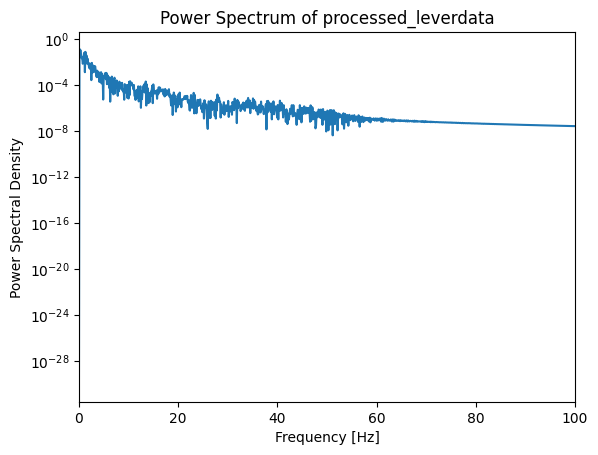

In [28]:
# set which trial to look at
trial_index = 10
view_processed_trial_FFT(trial_index, output_folder)